### Import python packages

In [2]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset
import csv #REMOVE ? not in use ?
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import shutil # to move folders
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings
import cdsapi # for copernicus function
import datetime # to have actual date

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_270664\4193067117.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Class

### Calendar class

In [2]:
# class to define parameter of time that remain constant durinf the whole script
class calendar:
    default_month = [ 
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                ]
    default_day = [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
                ]
    actual_date = datetime.date.today()
    actual_year = actual_date.year

### Map class

In [3]:
# this class contains all the latitude and logitude needed to do a map
class map_elements:
    parallels = np.arange(-360,360,10) # make latitude lines ever 10 degrees
    meridians = np.arange(-360,360,10) # make longitude lines every 10 degrees

### Copernicus class

In [4]:
## Definition of tuples that will be useful to search which data are available or not
# make it tuples to make unchangeable
class copernicus_elements:
    # there is 58 models
    models =('access_cm2','awi_cm_1_1_mr','bcc_csm2_mr','cams_csm1_0','canesm5_canoe','cesm2_fv2','cesm2_waccm_fv2','cmcc_cm2_hr4','cmcc_esm2','cnrm_cm6_1_hr','e3sm_1_0','e3sm_1_1_eca','ec_earth3_aerchem','ec_earth3_veg','fgoals_f3_l','fio_esm_2_0','giss_e2_1_g','hadgem3_gc31_ll','iitm_esm','inm_cm5_0','ipsl_cm6a_lr','kiost_esm','miroc6','miroc_es2l','mpi_esm1_2_hr','mri_esm2_0','norcpm1','noresm2_mm','taiesm1','access_esm1_5','awi_esm_1_1_lr','bcc_esm1','canesm5','cesm2','cesm2_waccm','ciesm','cmcc_cm2_sr5','cnrm_cm6_1','cnrm_esm2_1','e3sm_1_1','ec_earth3','ec_earth3_cc','ec_earth3_veg_lr','fgoals_g3','gfdl_esm4','giss_e2_1_h','hadgem3_gc31_mm','inm_cm4_8','ipsl_cm5a2_inca','kace_1_0_g','mcm_ua_1_0','miroc_es2h','mpi_esm_1_2_ham','mpi_esm1_2_lr','nesm3','noresm2_lm','sam0_unicon','ukesm1_0_ll')
    experiments = ('ssp1_1_9','ssp1_2_6','ssp4_3_4','ssp5_3_4os','ssp2_4_5','ssp4_6_0','ssp3_7_0','ssp5_8_5')
    experiments_historical=('historical',)

# Functions

### read_cckp_ncdata

In [5]:
#def read cckp (world bank) nc files
#reads data from world bank climate knowledge portal, nc files, with a single band
#assigns projection and exports to tif since zonal_stats seems to have issues with it otherwise (not ideal solution)
def read_cckp_ncdata(nc_path,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[0] as ncdata:
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata=ncdata.isel(time=0)
        ncdata.rio.to_raster(output)
       # output=output #here
   # else: 
      #  print(nc_path,"not found") # in this case, the data printed in the table will apply to the previous print.. 
       # output=0 #here
    return output       

#def read nc files (copernicus)
#reads data from CMIP6 Copernicus, nc files
#assigns projection and exports to tif since zonal_stats seems to have issues with it otherwise (not ideal solution)
def read_nc_data(nc_path,stats,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[3] as ncdata:
        # calculate statistiques for each variable
        if stats == 'mean':
            ncdata=ncdata.mean(dim='time')
        elif stats == 'median':
            ncdata=ncdata.median(dim='time')
        elif stats == 'p10':
            ncdata=ncdata.quantile(0.1, dim='time')
        elif stats == 'p90':
            ncdata=ncdata.quantile(0.9, dim='time')
        
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata.rio.to_raster(output)
    return output       

### get_cckp_file_name

In [6]:
#get filename from cckp based on ssp, period and gcm
def get_cckp_file_name(var,ssp='ssp245',period='2010-2039',gcm='median'):
    data_folder=r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets'
    if period in ['1991-2020']:
 #cru/era
    #Precipitation   
        if var in ['climatology-r50mm-annual-mean_era_annual','climatology-rx1day-monthly-mean_era_monthly','climatology-rx1day-annual-mean_era_annual','climatology-pr-annual-mean_era_annual','climatology-pr-monthly-mean_era_monthly']:
            filename='precipitation/wb_cckp/climatology-rx5day-annual-mean_era_annual_era5-0.5x0.5-climatology_mean_1991-2020.nc'
            filename=filename.replace('climatology-rx5day-annual-mean_era_annual',var)
        elif var in ['climatology-pr-annual-mean_cru']:
            filename='precipitation/wb_cckp/climatology-pr-annual-mean_cru_annual_cru-ts4.06-climatology_mean_1991-2020.nc'
    #Temperature
        elif var in ['climatology-tasmax-annual-mean_era','climatology-hd35-annual-mean_era','climatology-tas-annual-mean_era','climatology-hd40-annual-mean_era']:
            filename='temperature/wb_cckp/climatology-tasmax-annual-mean_era_annual_era5-0.5x0.5-climatology_mean_1991-2020.nc'
            filename=filename.replace('climatology-tasmax-annual-mean_era',var)                                                                                                                                 
        elif var in ['climatology-tasmax-annual-mean_cru']: 
            filename='temperature/wb_cckp/climatology-tasmax-annual-mean_cru_annual_cru-ts4.06-climatology_mean_1991-2020.nc' 
 #Realtime             
    elif period not in ['1991-2020']:
    #Precipitation     
        if var in ['frp100yr-rx1day-period-mean_cmip6_period','climatology-rx1day-annual-mean_cmip6_annual','frp50yr-rx1day-period-mean_cmip6_period','climatology-pr-monthly-mean_cmip6_monthly','climatology-pr-annual-mean_cmip6_annual','climatology-pr-seasonal-mean_cmip6_seasonal','changefactorfaep100yr-rx1day-period-mean_cmip6_period','anomaly-pr-monthly-mean_cmip6_monthly','climatology-rx5day-annual-mean_cmip6_annual']: 
            filename='precipitation/wb_cckp/frp100yr-rx1day-period-mean_cmip6_period_all-regridded-bct-ssp245-climatology_median_2010-2039.nc'   
            filename=filename.replace('2010-2039',period)
            filename=filename.replace('frp100yr-rx1day-period-mean_cmip6_period',var)                      
    #Temperature
        elif var in ['climatology-hd40','anomaly-hd40','anomaly-hd35','anomaly-tasmax','anomaly-txx','climatology-txx','anomaly-tas','climatology-tas']: 
            filename='temperature/wb_cckp/climatology-hd40-annual-mean_cmip6_annual_all-regridded-bct-ssp245-climatology_median_2020-2039.nc'
            filename=filename.replace('2020-2039',period)    
            filename=filename.replace('climatology-hd40',var)
        filename=filename.replace('ssp245',ssp)
        filename=filename.replace('median',gcm)
    data_path=os.path.join(data_folder,filename)
    return data_path
#import data from copernicus

### Period for the copernicus function

In [7]:
################################################ Period for copernicus function ################################################
# Aim of the function: by giving it a first and last year of the period that must analyzed, this function produce several 
# vectors,containing time informations, useful to download and treat data from CMIP6 projections (https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview )
# Those time vectors are used in the copernicus_data and the dataframe_copernicus and csv_copernicus functions

# function year_copernicus produce 
# year: a vector containing all the year in the period of interest
# year_str: a ???? containing all the year in the period of interest in the string format
# index: a ????? containing the index of the year and year_str
#### Parameters of the function
# first_year: number in int format, of the first year of the period of interest
# last_year: number in int format, of the last year of the period of interest
def year_copernicus(first_year,last_year):
    year = np.arange(first_year,(last_year+1),1) # create vector of years
    year_str = [0]*len(year) # create initiale empty vector to convert years in int
    index = np.arange(0,len(year)) # create vector of index for year
    i = 0 # initialize index
    for i in index: # convert all the date in string format
        year_str[i]=str(year[i])
    return (year, year_str, index)

# function date_copernicus produce 
# dates: the format depend on the temporal reolution, but always contain the dates of the period of interest.
#        with temporal_resolution=daily, dates is a DatetimeIndex
#        with temporal_resolution=monthly, dates is a list
# index_dates: an array containing the index of the dates
#### Parameters of the function
# temporal_resolution: daily or monthly
# year_str: ???? produce by function year_copernicus, containing the year of the period of interest in string format
def date_copernicus(temporal_resolution,year_str):
    start_date = "01-01-"+year_str[0] # string start date based on start year
    stop_date = "31-12-"+year_str[len(year_str)-1] # string stop date based on stop year
    if temporal_resolution =='daily':
        # vector of dates between start date and stop date
        dates = pd.date_range(start_date,stop_date)# dates is a pandas.core.indexes.datetimes.DatetimeIndex
        # By default, freq = 'D', which means calendar day frequency (source : https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases)
        #index_dates = np.arange(0,len(dates)) # vector containning index o dates vector
    if temporal_resolution =='monthly':
        dates = pd.date_range(start_date,stop_date,freq='MS') # vector of dates between start date and stop date
        dates=list(dates.strftime('%m-%Y')) # dates is an pandas.core.indexes.base.Index, not a pandas.core.indexes.datetimes.DatetimeIndex
    #if temporal_resolution =='fixed': trouver donnees pour gerer cela
    index_dates = np.arange(0,len(dates)) # vector containning index o dates vector
    return (dates, index_dates)

### Copernicus function
Some data comes from copernicus and can be directly taken form the website thans to CDS. The following functions serves this purpose
#### Parameters of the function :
projections-cmip6 : name of the web page, in this case, 'projections-cmip6'
format : zip or tar.gz
temporal_resolution : daily or monthly or fixed
SSP : sscenario that is studied "Historical", "SSP1-1.9", "SSP1-2.6" ...
Variable : variable to be studied
model: model of projection to choose
year: year of study to choose
area: area of study
month: month to be studied

In [8]:
################################################### Copernicus data function ###################################################
# Aim of the function : read nc data found on copernicus CMIP6 projections (https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview )
# Actions of this function
#     1) check which parameters are asked or not in the variables dictionnary, and modify the last depend on the parameters 
#        chosen by the user before
#     2) All this step is done in function try_download_copernicus: thanks to c.retrieve function and the variables dictionnary, 
#        the chosen data are download in zip format, dezipped and registered in a specific folder. 
#     3) the function looks in the specific folder for a nc format file, and once found, return the path of this nc format file

#### Parameters of the function
# temporal_resolution : daily or monthly or fixed
# SSP : sscenario that is studied "Historical", "SSP1-1.9", "SSP1-2.6" ...
# name_variable : variable to be studied
# model: model of projection to choose
# year: year(s) of study to choose
# area: area of study, if not specific, area should be an empty array area=[]
# path_for_file: path where the file must be unzipped
# out_path: path were all the outputs are registered, defined by the user in the begining of the main code
# name_area : to specify if we are only looking data for a project or for a wider zone

def copernicus_data(temporal_resolution,SSP,name_variable,model,year,area,path_for_file,out_path,name_area,source): 
    # create a path to register data
    if not os.path.isdir(path_for_file):
        print('path_for_file does not exist: the data may not have been downloaded')
        # create path for the downloaded file
        start_path = os.path.join(out_path,'Data_download_zip')
        file_download=create_period(start_path,name_variable,name_area,SSP,model,year,temporal_resolution,source) 
        
        
        if not os.path.isdir(file_download):
            print('file_download does not exist: the data were not downloaded')
            # function try to download from copernicus
            path_file = try_download_copernicus(temporal_resolution,SSP,name_variable,model,area,year,path_for_file,file_download,source)
            if path_file is None: # for this climate variable, the parameter do not fit
                return path_file
            final_path=search_for_nc(path_file) # looking for the netCDF file in format .nc and look if path length is a problem at the same time
            print('\n')
            print('---------------  Path to nc file exists ?? ---------------\n')
            print(os.path.isfile(final_path))
            print('\n')
            return final_path
            
        else: # if the path already exist, the data in zip format should also exists
            print('file_download does exist, the data have been downloaded, but not extracted')
            path_file=os.path.join(path_for_file,source)# source was added because of a problem during downloading
            final_path=search_for_nc(path_file) # looking for the netCDF file in format .nc and look if path length is a problem at the same time
            if final_path is None:# if no nc file exists, need to check again if the file with those parameters exists
                final_path = try_download_copernicus(temporal_resolution,SSP,name_variable,model,area,year,path_for_file,file_download,source)
                final_path = search_for_nc(final_path) # looking for the netCDF file in format .nc and look if path length is a problem at the same time
            return final_path
                
    else: # the path for the file exists
        path_file=os.path.join(path_for_file,source)# data was added because of a problem during downloading
        final_path=search_for_nc(path_file) # looking for the netCDF file in format .nc and look if path length is a problem at the same time
        if final_path is None: # if no nc file exists, need to check again if the file with those parameters exists
            final_path = try_download_copernicus(temporal_resolution,SSP,name_variable,model,area,year,path_for_file,file_download,source)
            final_path = search_for_nc(final_path) # looking for the netCDF file in format .nc and look if path length is a problem at the same time
        return final_path

In [9]:
def try_download_copernicus(temporal_resolution,SSP,name_variable,model,area,year,path_for_file,file_download,source):
    c = cdsapi.Client()# function to use the c.retrieve
    # basic needed dictionnary to give to the c.retrieve function the parameters asked by the user
    variables = {
                'format': 'zip', # this function is only designed to download and unzip zip files
                'temporal_resolution': temporal_resolution,
                'experiment': SSP,
                'variable': name_variable,
                'model': model,
    }

    if area != []: # the user is interested by a sub region and not the whole region 
        variables.update({'area':area}) 

    if name_variable == 'air_temperature':
        variables['level'] = '1000' # [hPa], value of the standard pressure at sea level is 1013.25 [hPa], so 1000 [hPa] is the neareste value. Other pressure value are available but there is no interest for the aim of this project

    if temporal_resolution != 'fixed':# if 'fixed', no year, month, date to choose
        variables['year']=year # period chosen by the user
        variables['month']= calendar.default_month  # be default, all the months are given; defined in class calendar
        if temporal_resolution == 'daily':
            variables['day']= calendar.default_day # be default, all the days are given; defined in class calendar
    # c.retrieve download the data from the website
    try:
        c.retrieve(
            'projections-cmip6',
            variables,
            'download.zip') # the file in a zip format is registered in the current directory
    except:
        print('Some parameters are not matching')
        return # stop the function, because some data the user entered are not matching
    
    # function to extract the downloaded zip
    path_file=download_extract(path_for_file,file_download,source)
    return path_file

In [10]:
# download_extract functions aims to return the path were the downloaded file in zip format is extracted

def download_extract(path_for_file,file_download,source):
    os.makedirs(path_for_file) # to ensure the creation of the path
    # unzip the downloaded file
    from zipfile import ZipFile
    zf = ZipFile('download.zip', 'r')
    zf.extractall(source) # if no precision of directory, extract in current directory
    zf.close()

    os.makedirs(file_download) # to ensure the creation of the path
    # moving download to appropriate place
    shutil.move('download.zip',file_download) # no need to delete 'download.zip' from inital place
    
    shutil.move(source,path_for_file) # move extracted data to the path created for them
    path_file=os.path.join(path_for_file,source)
    print('\n The downloaded file is extracted')
    return path_file

In [22]:
# seach_for_nc is a function looking in path_for_file for a document in .nc format

def search_for_nc(path_for_file):
    print('path_for_file does exist Function copernicus search for nc')
    for file in os.listdir(path_for_file):
        if file.endswith(".nc"):
            final_path=os.path.join(path_for_file, file)
            
            print('The file is in the path Function copernicus search for nc\n')
            print('Before path_length, The final path for the nc file is: '+final_path)
            answer = str(os.path.isfile(final_path))
            print('\n The final path for nc file exists ? '+answer+'\n')
            final_path=path_length(final_path) # check if length of path is too long
            print('After path_length, The final path for the nc file is: '+final_path)
            answer = str(os.path.isfile(final_path))
            print('\n The final path for nc file exists ? '+answer+'\n')
            return final_path # the function returns the path of the nc file of interest
            break # stop the function if a nc file was found 
        else:
            pass
    # the all folder has been search and there is no nc file in it
    print('Problem : No nc file was found Function copernicus Function copernicus search for nc')# this line is out of the for loop, 
    #because it should only appear once all the folder has been examinated and if the break of the if was not used

In [12]:
# this functions test if the path is too long
# if the path is more than 260 char, the path wll be modified in order for windows to accept is as a path

def path_length(str1):
    if len(str1)>260:
        path = os.path.abspath(str1) # normalize path
        if path.startswith(u"\\\\"):
            path=u"\\\\?\\UNC\\"+path[2:]
        else:
            path=u"\\\\?\\"+path
        return path
    else:
        return str1

In [13]:
# function to create path for the downloaded file
def create_period(start_path,name_variable,name_area,SSP,model,year,temporal_resolution,source):
    # adapt the name of the folder fot the period, depending on the type of period
    if len(year)==1:
        file_download = os.path.join(start_path,name_variable,name_area,SSP,model,year,source)
    elif len(year)>1:
        period=year[0]+'-'+year[len(year)-1]
        file_download = os.path.join(start_path,name_variable,name_area,SSP,model,period,source)
    elif temporal_resolution == 'fixed':
        file_download = os.path.join(start_path,name_variable,name_area,SSP,model,'fixed_period',source)
    return file_download

### Registering data in dataframe and csv form copernicus CMIP6

In [14]:
########################################### Register data from nc file of Copernicus ############################################
# Aim of the function: this function aims to register in a dataframe and a csv file the data from the nc file downloaded with
# the function copernicus_data
# Actions of this function
#     1) Create the string indicating the period of interest
#     2) Creating path and file name to register dataframe in csv file
#     3) Register data, with its corresponding experiments and models, in dataframe and csv file
#        3 a) Test if path does not exists (if dataframe is not registered) : 
#                1 . Thanks to copernicus_data, download nc fils from copernicus CMIP6 website for each experiment and each model
#                2 . Open the dowloaded nc file in the jupyter notebook if it exists
#                3 . In a dataframe, register the value in the nc file, for each experiment, model and day
#                4 . If there no value for each experiments and models tested, the datfram is empty and the user is informed
#        3 b) Test if path exists (dataframe is registered) : no need to register again, return in dataframe the existing 
#             csv file in a dataframe

# Parameters of the function
# temporal_resolution: 'daily', 'monthly', or 'fixed'. String type 
# year_str: list containing all the years under the string type and in the period of interest
# experiments: copernicus_elements.experiments
# models: copernicus_elements.models
# out_path: path were the outputs are registered. Defined by the user at the beginning of the code 
# global_variable: global name of the climate variable of interest (example: Wind)
# name_variable: name of the elements downloaded from copernicus (example: 'near_surface_wind_speed')
# name_project: Name of the project for which the data are taken
# area: list containing latitudes and logitudes around the project

def csv_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area,source):    
    ### PROBLEM WITH DATES, CAN T just pass one year. year str is a list, so if one year (2020,)
    ## PROBLEM WITH PATH: not coherent between data csv, datasets, download. And not achieving to have project name in path for dataset
    ## maybe the name for dataset is too long, but even if end at name project, does not work. Try doing one string with name project in it
    ## PROBLEM WITH PATH: WORK BUT NOT IDEAL
    ## pourquoi mettre toutes les donnees dans un dataframe ?? permet d'avoir cette organisation en multiindex. Sinon, on ne peut pas faire ca
    print('############################### Project name: '+name_project+' ###############################')
    
    # create string for name of folder depending on type of period
    if temporal_resolution == 'fixed':
        period = 'fixed'
    else:
        period=year_str[0]+'-'+year_str[len(year_str)-1]
    
    # modification on name_project str to ensure no problem whent using this str as name of a folder
    name_project = name_project.replace('-','_') # take off every blank space of project names
    name_project = name_project.replace('/','_') # take off every / of project names
    name_project = name_project.replace(r'"\"','_') # take off every \ of project names
    # brackets shouldn't be a problem for name projects
        
    (dates, index_dates)=date_copernicus(temporal_resolution,year_str) # create time vector depending on temporal resolution

    title_file = name_project +'_' +period+ '_' + temporal_resolution + '_' +name_variable#+'.csv'
    
    path_for_csv = os.path.join(out_path,'csv',source,name_variable,name_project,period) # create path for csv file

    if not os.path.isdir(path_for_csv): # test if the data were already downloaded; if not, first part if the if is applied
        os.makedirs(path_for_csv) # to ensure the creation of the path
        # the dataframe_copernicus functions aims to test if the data with the specific parameters exists (with copernicus_data)
        # and then produce a csv file if the data exists
        (df,period)=dataframe_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area,period,index_dates,dates,path_for_csv,title_file,source)
        return df,period
    else:# test if the data were already downloaded; if yes, this part of the if is applied
        if len(os.listdir(path_for_csv)) == 0: #test if the directory is empty
            # the csv file does not exist, even if the path exist
            # the dataframe_copernicus functions aims to test if the data with the specific parameters exists (with copernicus_data)
            # and then produce a csv file if the data exists
            (df,period)=dataframe_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area,period,index_dates,dates,path_for_csv,title_file,source)
        else: # the directory is not empty
            df=file_already_downloaded(path_for_csv,title_file)

        return df,period

In [15]:
# the dataframe_copernicus functions aims to test if the data with the specific parameters exists (with copernicus_data)
# and then produce a csv file if the data exists

def dataframe_copernicus(temporal_resolution,year_str,experiments,models,out_path, global_variable, name_variable, name_project,area,period,index_dates,dates,path_for_csv,title_file,source):    
    print('FUNCTION DATAFRAME_COPERNICUS')
    df = pd.DataFrame() # create an empty dataframe
    for SSP in experiments:
        experiment = (SSP,) # create tuple for iteration of dataframe
        print('Test with scenario '+SSP)
        for model_simulation in models:
            model =(model_simulation,) # create tuple for iteration of dataframe
            print('Test with model '+model_simulation)
            # path were the futur downloaded file is registered
            path_for_file= os.path.join(out_path,'Datasets',name_variable,name_project,SSP,model_simulation,period)
            # existence of path_for_file tested in copernicus function
            climate_variable_path=copernicus_data(temporal_resolution,SSP,name_variable,model_simulation,year_str,area,path_for_file,out_path,name_project,source)
            # area is determined in the "Load shapefiles and plot" part
            if (climate_variable_path is not None):
                # register data concerning each project under the form of a csv, with the model, scenario, period, latitude and longitude
                df=register_data(climate_variable_path,name_project,index_dates,dates,experiment,model,df)
                print('\nValue were found for the period and the project tested\n')
            else:
                print('\nNo value were found for the period and the project tested\n')
                continue # do the next for loop
        # test if dataframe is empty, if values exist for this period
    if not df.empty: # if dataframe is not empty, value were registered, the first part is run : a path to register the csv file is created, and the dataframe is registered in a csv file
        full_name = os.path.join(path_for_csv,title_file)
        print(full_name)
        df.to_csv(full_name) # register dataframe in csv file
        return df,period 
    else: # if the dataframe is empty, no value were found, there is no value to register or to return
        #os.remove(path_for_file)# remove path
        return df,period# there is no dataframe to return

In [16]:
# register data concerning each project under the form of a csv, with the model, scenario, period, latitude and longitude
def register_data(climate_variable_path,name_project,index_dates,dates,experiment,model,df):
    print('Registering the data in a dataframe')
    Open_path = Dataset(climate_variable_path) # open netcdf file
    lat_dataframe = np.ma.getdata(Open_path.variables['lat']).data
    lon_dataframe = np.ma.getdata(Open_path.variables['lon']).data
    column_name = find_column_name(Open_path)
    data_with_all = ma.getdata(Open_path.variables[column_name]).data

    for moment in index_dates: # case if temporal resolution is daily
        data_dataframe = data_with_all[moment,:,:]
        Date = (dates[moment],) # create tuple for iteration of dataframe
        Name_Project = (name_project,)

        # Create the MultiIndex
        midx = pd.MultiIndex.from_product([Name_Project,experiment, model, Date, lat_dataframe],names=['Name project','Experiment', 'Model', 'Date', 'Latitude'])
        # multiindex to name the columns
        lon_str = ('Longitude',)
        cols = pd.MultiIndex.from_product([lon_str,lon_dataframe])
        # Create the Dataframe
        Variable_dataframe = pd.DataFrame(data = data_dataframe, 
                                    index = midx,
                                    columns = cols)
        # Concatenate former and new dataframe
        df = pd.concat([df,Variable_dataframe])# register information for project

    Open_path.close # to spare memory
    return df

In [21]:
# function to return column name in the netCDF file
# all netCDF file form copernicus have this format for their variables names
# ['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds', Name of climate variable of interest]
# take of 'time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds'
def find_column_name(Open_path):
    # make a list with every variables of the netCDF file of interest
    climate_variable_variables=list(Open_path.variables)
    # variables that are not the column name of interest 
    elements_not_climate_var =['time', 'time_bnds', 'bnds','lat', 'lat_bnds', 'lon', 'lon_bnds','time_bounds','bounds','lat_bounds','lon_bounds']
    for str in elements_not_climate_var:
        if str in climate_variable_variables:
            climate_variable_variables.remove(str)
    return climate_variable_variables[0]

In [18]:
def file_already_downloaded(path_for_csv,title_file):
    print('The file was already downloaded')
    df = pd.read_csv(os.path.join(path_for_csv,title_file)) # read the downloaded data for the analysis

    # changing name of columns
    name_columns=df.iloc[0].array
    df.rename(columns={'Unnamed: 0':'Experiment','Unnamed: 1':'Model','Unnamed: 2':'Date','Unnamed: 3':'Latitude'}, inplace=True)

    lon_dataframe=name_columns[4:len(name_columns)] # register data for columns of multiindex

    df.drop([0,1], axis=0,inplace=True) # remove 2 first lines

    # recreate multiindex 

    # .... with columns
    df.set_index(['Name project','Experiment', 'Model', 'Date','Latitude'],inplace=True)

    # .... with lines
    lon_str = ('Longitude',)
    cols = pd.MultiIndex.from_product([lon_str,lon_dataframe])
    df.columns=cols
    return df

### Display map

In [19]:
# function to display a map
def Display_map(indexes_lat,indexes_lon,lat,lon,lat_min_wanted,lat_max_wanted,lon_min_wanted,lon_max_wanted,data,title_png,title_to_adapt,label,parallels,meridians):#,projects):

    lon_moz, lat_moz = np.meshgrid(lon, lat) # this is necessary to have a map
    
    # create Map
    fig = plt.figure()
    plt.title(title_to_adapt) # title of the map # automatized with year
    map = Basemap(projection ='merc',llcrnrlon=lon_min_wanted+5,llcrnrlat=lat_min_wanted+2,urcrnrlon=lon_max_wanted-5,urcrnrlat=lat_max_wanted-2,resolution='i', epsg = 4326) # projection, lat/lon extents an
    # adding and substracting a quantity to the lon and lat to have a bit of margin when presenting it
    # substracting more to longitude because the range of longitude is -180 to 180. The range of latitude is -90 to 90
    map.drawcountries()
    map.drawcoastlines()
    map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    temp = map.contourf(lon_moz,lat_moz,data)
    #projects.plot(ax=ax) # project in projection EPSG:4326
    cb = map.colorbar(temp,"right", size="5%", pad="2%") # color scale, second parameter can be locationNone or {'left', 'right', 'top', 'bottom'}
    cb.set_label(label) # name for color scale
    plt.savefig(os.path.join(out_path,'figures',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
    plt.show()

### Display map project

In [20]:
########################################## Display project on map ############################################
# This function aims to display every projects wanted by the user with a map as a background
### Parameters of the function : 
# projects: geopanda.dataframe containing projects information
# study_area: geopanda.dataframe containing study_area information
# str_interest: string of the climate variable of interest to be represented
# title_for_image: title for image composed of subplots
# number_rows: the user should indicate the number of rows for the subplots
# number_cols: the user should indicate the number of cols for the subplots
# out_path: begenning of the path to register the image

def Display_map_projects(projects,study_area,str_interest,title_for_image,number_rows, number_cols,out_path):
    
    # select climate variable to be represented
    columns_to_represent= list(projects.filter(regex=str_interest).columns) # select columns that should be presented in plots
    columns_to_represent2=[ ('\n').join(k.split(' ')[-2:])  for k in columns_to_represent] # delete 'water stress' from 
    # the list column_to_represent and insert \n to do a back to line
    number_plots = len(columns_to_represent)
    
    # create figure
    fig, axs = plt.subplots(nrows=number_rows,ncols=number_cols, sharex=True, sharey=True,figsize=(8,8))
    
    k=0
    # map in the subplot
    for i in np.arange(0,3):# columns
        for j in np.arange(0,2): # linesfor i in np.arange(0,number_plots):
            base = study_area.plot(ax=axs[j][i],color='white', edgecolor='black')# background is map of the study area presenting 
            # country borders of this area
            projects.plot(ax=axs[j][i], column=columns_to_represent[k])# plot the projects as points; legeng = True 
            # impose a color for the projects point dpeending on the value in the column

            # give subplot a title
            ax_created = axs[j][i]
            ax_created.title.set_text(columns_to_represent2[k])
            
            k+=1 # incrementation to iterate columns_to_represent

    plt.legend()
    plt.suptitle(title_for_image) # give a global name to the image
    plt.savefig(os.path.join(out_path,'figures',str_interest,title_for_image),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
    plt.show()

## Return period function

In [55]:
## PROBELM : when 2 values are the same, what happens ????
# curve fitting, how to find equation representing, possible to install scipy : https://www.geeksforgeeks.org/scipy-curve-fitting/
def return_period(data_series):
    # rank data
    data_series.sort(reverse=True)
    N = len(data_series)
    rank=np.arange(N,0,-1,dtype=int)
    # give return period of each value in the time period given
    P = rank / (N+1) # rank / (N+1)
    T=1/P
    plt.plot(T,sorted_data_series)
    plt.xlabel('Return period')
    plt.ylabel('Climate variable of interest')
    
    return data_series,T

In [52]:
# to test return_period

import random

randomlist = random.sample(range(100, 500), 365)

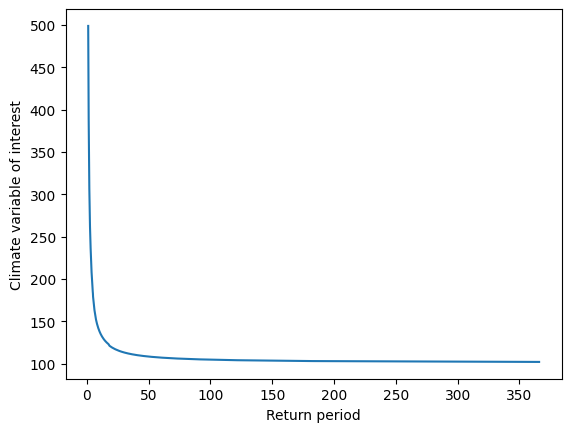

In [56]:
(ranked_data_series,T)=return_period(randomlist)

In [ ]:
## scipy 
import numpy as np
 
# curve-fit() function imported from scipy
from scipy.optimize import curve_fit
 
from matplotlib import pyplot as plt

In [ ]:
def probability_of_exceedance():
    